### Market Comments Dataset Overview

This dataset contains 14,281 rows and 8 columns, including customer reviews for various market products. The dataset includes item categories, brands, user information, comment text, ratings, and sentiment labels.

## Features in the Dataset
* item_category : Category of the product being reviewed (e.g., electronics, appliances, etc.).
* item_id : Unique identifier for each product.
* brand	: Encoded brand ID for each product.
* user_id : Unique user identifier who posted the comment.
* date : The date the comment was posted (YYYY-MM-DD format).
* comment : The actual text review left by the customer.
* rating : The numerical rating given by the user (range: 1.0 - 5.0).
* tonality : The sentiment label of the comment (positive, negative, neutral).


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import nltk

nltk.download('stopwords')
nltk.download('punkt')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/consumer-sentiments-and-ratings/market_comments.csv


# TEXT PREPROCESSING

## Function to clean text

In [2]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    words = word_tokenize(text)  # Tokenize words
    words = [word for word in words if word not in stopwords.words('russian')]  # Remove Russian stopwords
    return " ".join(words)

## Load dataset

In [3]:
df = pd.read_csv("/kaggle/input/consumer-sentiments-and-ratings/market_comments.csv").dropna()

## Extract comments and labels

In [4]:
comments = df['comment'].astype(str).apply(clean_text).values  # Apply text cleaning
labels = df['tonality'].values

## Check unique sentiment classes

In [5]:
unique_classes = np.unique(labels)
num_classes = len(unique_classes)
print(f"Detected {num_classes} sentiment classes: {unique_classes}")

Detected 2 sentiment classes: ['negative' 'positive']


## Encode labels

In [6]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# TOKENIZATION & PADDING

## Tokenize comments

In [7]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

## Padding sequences

In [8]:
max_length = 150  # Ensure consistent length
data_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


## Split data into training and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_padded, categorical_labels, test_size=0.2, random_state=537)


# BUILDING LSTM MODEL

In [10]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=20000, output_dim=256)(input_layer)
bidirectional_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout_1 = Dropout(0.4)(bidirectional_lstm)
lstm_2 = LSTM(64, return_sequences=True)(dropout_1)
dropout_2 = Dropout(0.4)(lstm_2)
lstm_3 = LSTM(32)(dropout_2)
dense_layer = Dense(64, activation='relu')(lstm_3)
dropout_3 = Dropout(0.3)(dense_layer)
output_layer = Dense(num_classes, activation='softmax')(dropout_3)

## Create model

In [11]:
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

## Compile model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# TRAINING THE MODEL

In [13]:
epochs = 100  # More epochs for better learning
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 821ms/step - accuracy: 0.8148 - loss: 0.4797 - val_accuracy: 0.8372 - val_loss: 0.4447
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 836ms/step - accuracy: 0.8348 - loss: 0.4527 - val_accuracy: 0.8372 - val_loss: 0.4444
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 841ms/step - accuracy: 0.8397 - loss: 0.4446 - val_accuracy: 0.8372 - val_loss: 0.4445
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 820ms/step - accuracy: 0.8428 - loss: 0.4409 - val_accuracy: 0.8372 - val_loss: 0.4442
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 833ms/step - accuracy: 0.8399 - loss: 0.4440 - val_accuracy: 0.8372 - val_loss: 0.4453
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 816ms/step - accuracy: 0.8361 - loss: 0.4510 - val_accuracy: 0.8372 - val_loss: 0.4442
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 815ms/step - accuracy: 0.8292 - loss: 0.4595 - val_accuracy: 0.8372 - val_loss: 0.4442
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 806ms/step - accuracy: 0.8374 - loss: 0.4464 - 

## Plot training results

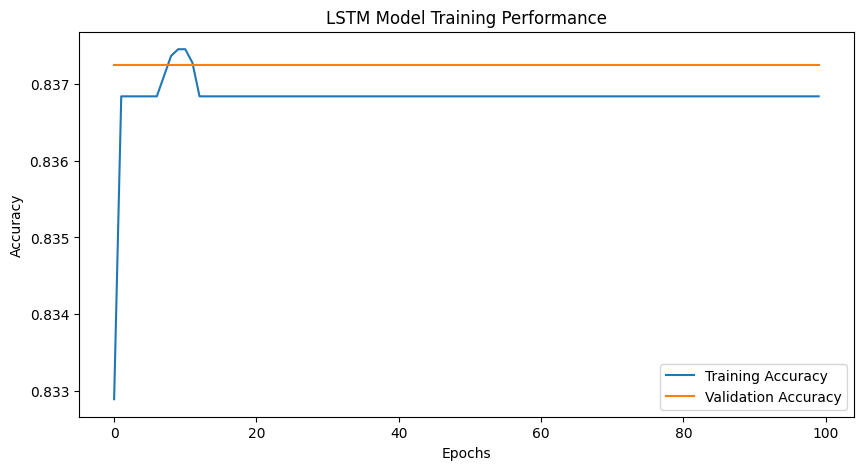

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Model Training Performance')
plt.show()

# MODEL EVALUATION

In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step


## Confusion Matrix

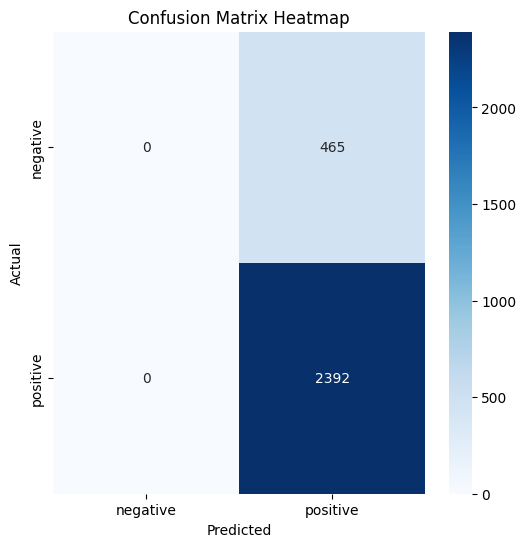

In [16]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Classification Report

In [17]:
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00       465
    positive       0.84      1.00      0.91      2392

    accuracy                           0.84      2857
   macro avg       0.42      0.50      0.46      2857
weighted avg       0.70      0.84      0.76      2857



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SENTIMENT PREDICTION FUNCTION

In [18]:
def predict_sentiment(comment):
    comment = clean_text(comment)  # Clean the input comment
    seq = tokenizer.texts_to_sequences([comment])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded)[0]
    return label_encoder.inverse_transform([np.argmax(prediction)])[0]

# EXAMPLE PREDICTIONS (RU & EN)

In [19]:
example_comments = [
    ("Этот товар мне очень понравился, рекомендую!", "I really liked this product, I recommend it!"), 
    ("Качество ужасное, не стоит своих денег.", "The quality is terrible, not worth the money."), 
    ("Ну, неплохо, но ожидал лучшего.", "Well, not bad, but I expected better."),
    ("После покупки я разочарован, не советую.", "After purchase, I'm disappointed, don't recommend."), 
    ("Это лучшая вещь, что я когда-либо покупал!", "This is the best thing I have ever bought!"), 
    ("Выглядит хорошо, но есть некоторые недостатки.", "Looks good, but has some drawbacks."), 
    ("Категорически не рекомендую, ужасное качество.", "Absolutely do not recommend, terrible quality."), 
    ("Описание точное, товар полностью соответствует.", "The description is accurate, the product matches perfectly."), 
    ("Не знаю, что сказать, нормально, но не идеально.", "I don't know what to say, it's okay, but not perfect."), 
    ("Ожидания не оправдались, но и не худший вариант.", "Expectations were not met, but it's not the worst option.") 
]

for comment, translation in example_comments:
    sentiment = predict_sentiment(comment)
    print(f"Comment (RU): {comment}\nComment (EN): {translation}\nSentiment: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Comment (RU): Этот товар мне очень понравился, рекомендую!
Comment (EN): I really liked this product, I recommend it!
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Comment (RU): Качество ужасное, не стоит своих денег.
Comment (EN): The quality is terrible, not worth the money.
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Comment (RU): Ну, неплохо, но ожидал лучшего.
Comment (EN): Well, not bad, but I expected better.
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Comment (RU): После покупки я разочарован, не советую.
Comment (EN): After purchase, I'm disappointed, don't recommend.
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Comment (RU): Это лучшая вещь, что я когда-либо покупал!
Comment (EN): This is the best thing I have ever bought!
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Comment (RU): Выглядит хорошо, но есть некоторые недостатки.
Comment (EN): Looks good, but has some dra

# Summary
This LSTM-based sentiment analysis model processes market-related comments to classify them as positive, negative, or neutral. The model dynamically adjusts based on the number of detected sentiment classes.

## Key Steps in the Code
### Text Preprocessing
* Converts text to lowercase.
* Removes punctuation and numbers.
* Tokenizes words and removes stopwords (in Russian).
### Tokenization & Padding
* Converts words into numerical sequences.
* Ensures all comments have the same length using pad_sequences().
### Building the LSTM Model
* Uses Bidirectional LSTM for better text understanding.
* Includes Dropout layers to prevent overfitting.
* The output layer dynamically adjusts to the number of detected sentiment classes.
### Training the Model
* Trained for 100 epochs using categorical cross-entropy loss.
* Training accuracy is visualized using matplotlib.
### Model Evaluation
* Confusion Matrix Heatmap is generated for test results.
* A classification report provides precision, recall, and F1-score.
### Sentiment Prediction Function
* Predicts the sentiment of new comments after text processing.
### Example Predictions
* 10 sample comments in Russian with English translations are tested.

## Outcome
* This model automatically classifies market-related comments into sentiment categories.
* It adapts to different sentiment class distributions dynamically.
* Visualization techniques like heatmaps and accuracy curves help in performance evaluation.

### Thank you for taking the time to review my work. I would be very happy if you could upvote! 😊